In [1]:
## Import necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from tqdm import tqdm
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the metadata CSV file
metadata_path = r'C:\Users\ainle\OneDrive\Attachments\Desktop\project\Environmental-SoundScape-Classification\UrbanSound8K.csv'
metadata = pd.read_csv(metadata_path)

# Display class distribution
print(metadata['class'].value_counts())


class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


In [3]:
# Define a function to extract features with additional spectral features
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    
    # MFCC features
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    
    # Spectral features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sample_rate))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio))
    
    # Combine all features
    combined_features = np.hstack((mfccs_scaled_features, spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate))
    return combined_features


In [4]:

# Path to the dataset
audio_dataset_path = r'C:\Users\ainle\OneDrive\Attachments\Desktop\project\Environmental-SoundScape-Classification\audio'

# Clean and validate metadata
metadata = metadata.dropna(subset=['fold', 'slice_file_name'])  # Remove rows with missing values

# Remove decimal points from 'fold' and convert to strings
metadata['fold'] = metadata['fold'].apply(lambda x: str(x).split('.')[0])

# Initialize list for extracted features
extracted_features = []

# Feature extraction loop
for index_num, row in tqdm(metadata.iterrows(), total=len(metadata)):
    try:
        # Construct the file path
        file_name = os.path.join(audio_dataset_path, 'fold' + row["fold"], row["slice_file_name"])
        
        # Check if the file exists
        if not os.path.exists(file_name):
            print(f"File not found: {file_name}")
            continue  # Skip missing files
        
        # Extract features
        final_class_labels = row["class"]
        data = features_extractor(file_name)
        extracted_features.append([data, final_class_labels])
    
    except Exception as e:
        print(f"Error processing file {file_name}: {e}")

# Convert extracted features to a DataFrame
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])

# Save the features to a file for future use
extracted_features_df.to_pickle('extracted_features.pkl')  # Save as a binary file


100%|██████████| 8732/8732 [17:42<00:00,  8.22it/s]   


In [5]:
# Load features
extracted_features_df = pd.read_pickle('extracted_features.pkl')

# Prepare features (X) and labels (y)
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())

# Encode labels
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)


Training Data Shape: (6985, 44)
Test Data Shape: (1747, 44)


In [6]:

# Determine the correct number of features
num_features = X_train.shape[1]  # Automatically detect the feature size

# Reshape the data for CNN
X_train_cnn = X_train.reshape(X_train.shape[0], num_features, 1, 1)
X_test_cnn = X_test.reshape(X_test.shape[0], num_features, 1, 1)

# Build the CNN model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, kernel_size=(3, 1), activation='relu', input_shape=(num_features, 1, 1)))  # Adjust input shape
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Conv2D(64, kernel_size=(3, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Conv2D(128, kernel_size=(3, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))

model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_cnn, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_cnn, y_test),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3167 - loss: 8.4343 - val_accuracy: 0.3211 - val_loss: 5.1550 - learning_rate: 0.0010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5746 - loss: 3.8985 - val_accuracy: 0.3326 - val_loss: 3.4149 - learning_rate: 0.0010
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6688 - loss: 2.3901 - val_accuracy: 0.4556 - val_loss: 2.5205 - learning_rate: 0.0010
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7203 - loss: 1.7123 - val_accuracy: 0.6005 - val_loss: 1.8779 - learning_rate: 0.0010
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7717 - loss: 1.3248 - val_accuracy: 0.7218 - val_loss: 1.3769 - learning_rate: 0.0010
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7854 - loss: 1.1622 - val_accuracy: 0.7974 - val_loss: 1.0637 - learning_rate: 0.0010
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8175 - l

In [7]:
# Evaluate the improved model
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8901 - loss: 0.4578
Test Accuracy: 89.81%


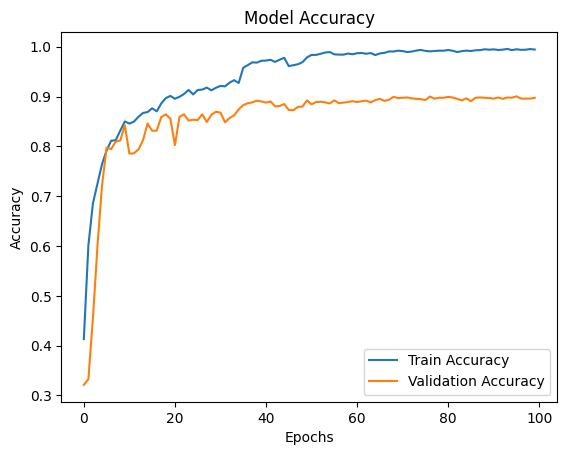

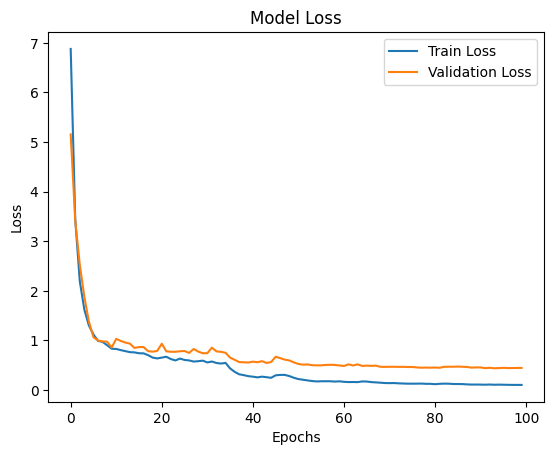

In [8]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [9]:
# Predict on the test set
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=labelencoder.classes_))


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
                  precision    recall  f1-score   support

 air_conditioner       0.95      0.96      0.95       203
        car_horn       0.97      0.87      0.92        86
children_playing       0.80      0.85      0.83       183
        dog_bark       0.83      0.86      0.84       201
        drilling       0.91      0.88      0.90       206
   engine_idling       0.95      0.96      0.96       193
        gun_shot       0.82      0.85      0.84        72
      jackhammer       0.96      0.95      0.95       208
           siren       0.94      0.96      0.95       165
    street_music       0.86      0.80      0.83       230

        accuracy                           0.90      1747
       macro avg       0.90      0.90      0.90      1747
    weighted avg       0.90      0.90      0.90      1747



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted Class for C:\Users\ainle\OneDrive\Attachments\Desktop\project\Environmental-SoundScape-Classification\audio\fold1\7383-3-0-0.wav:
 dog_bark


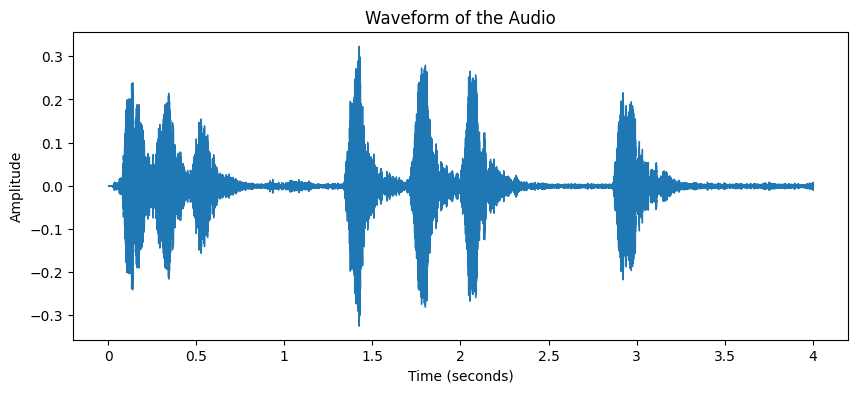

In [10]:

# Function to predict the class and show the waveform of a custom audio file
def predict_and_display_audio(file_path):
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: The file at {file_path} does not exist.")
        return None

    try:
        # Load audio file using librosa
        audio, sr = librosa.load(file_path)

        # Extract features (e.g., Mel spectrogram)
        features = features_extractor(file_path)

        # Reshape features to match model input
        features_reshaped = features.reshape(1, features.shape[0], 1, 1)

        # Make prediction
        predicted_label = model.predict(features_reshaped)
        predicted_class = labelencoder.inverse_transform([np.argmax(predicted_label)])

        # Print predicted class
        print(f"Predicted Class for {file_path}:\n {predicted_class[0]}")

        # Plot waveform
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr)
        plt.title("Waveform of the Audio")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.show()

        # Play the audio
        return Audio(file_path)

    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
        return None


# Updated file path
custom_audio_path = r'C:\Users\ainle\OneDrive\Attachments\Desktop\project\Environmental-SoundScape-Classification\audio\fold1\7383-3-0-0.wav'

# Example usage with a custom audio file
predict_and_display_audio(custom_audio_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Predicted Class for C:\Users\ainle\OneDrive\Attachments\Desktop\project\Environmental-SoundScape-Classification\audio\fold5\6508-9-0-4.wav:
 street_music


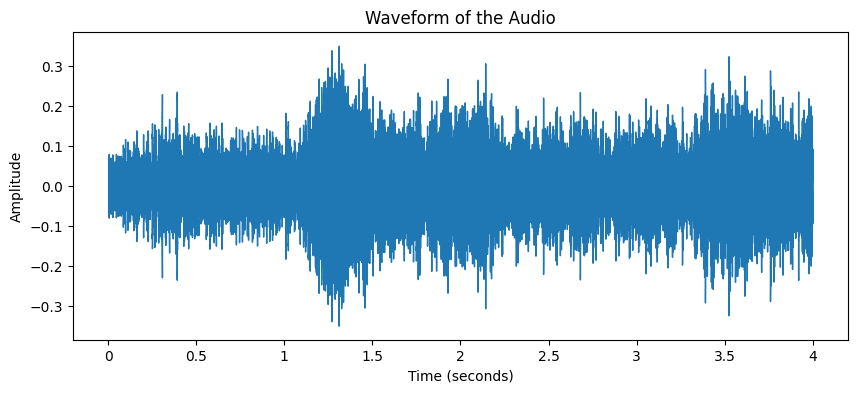

In [11]:

# Function to predict the class and show the waveform of a custom audio file
def predict_and_display_audio(file_path):
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: The file at {file_path} does not exist.")
        return None

    try:
        # Load audio file using librosa
        audio, sr = librosa.load(file_path)

        # Extract features (e.g., Mel spectrogram)
        features = features_extractor(file_path)

        # Reshape features to match model input
        features_reshaped = features.reshape(1, features.shape[0], 1, 1)

        # Make prediction
        predicted_label = model.predict(features_reshaped)
        predicted_class = labelencoder.inverse_transform([np.argmax(predicted_label)])

        # Print predicted class
        print(f"Predicted Class for {file_path}:\n {predicted_class[0]}")

        # Plot waveform
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr)
        plt.title("Waveform of the Audio")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.show()

        # Play the audio
        return Audio(file_path)

    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
        return None


# Updated file path
custom_audio_path = r'C:\Users\ainle\OneDrive\Attachments\Desktop\project\Environmental-SoundScape-Classification\audio\fold5\6508-9-0-4.wav'

# Example usage with a custom audio file
predict_and_display_audio(custom_audio_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Class for C:\Users\ainle\OneDrive\Attachments\Desktop\project\Environmental-SoundScape-Classification\audio\fold3\6988-5-0-2.wav:
 engine_idling


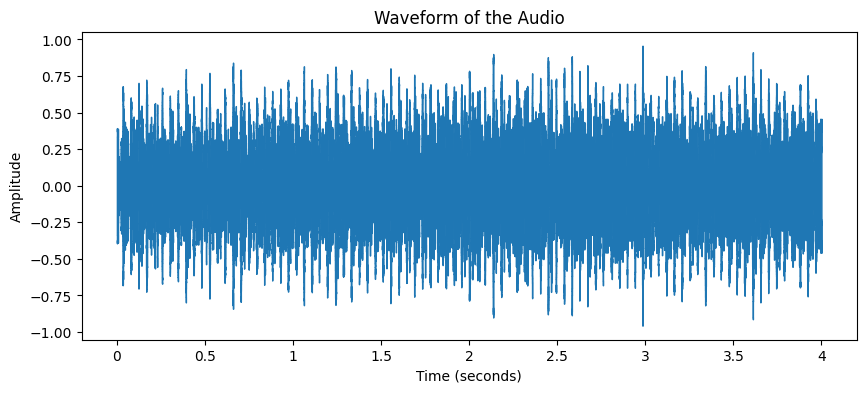

In [12]:

# Function to predict the class and show the waveform of a custom audio file
def predict_and_display_audio(file_path):
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"Error: The file at {file_path} does not exist.")
        return None

    try:
        # Load audio file using librosa
        audio, sr = librosa.load(file_path)

        # Extract features (e.g., Mel spectrogram)
        features = features_extractor(file_path)

        # Reshape features to match model input
        features_reshaped = features.reshape(1, features.shape[0], 1, 1)

        # Make prediction
        predicted_label = model.predict(features_reshaped)
        predicted_class = labelencoder.inverse_transform([np.argmax(predicted_label)])

        # Print predicted class
        print(f"Predicted Class for {file_path}:\n {predicted_class[0]}")

        # Plot waveform
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr)
        plt.title("Waveform of the Audio")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.show()

        # Play the audio
        return Audio(file_path)

    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
        return None


# Updated file path
custom_audio_path = r'C:\Users\ainle\OneDrive\Attachments\Desktop\project\Environmental-SoundScape-Classification\audio\fold3\6988-5-0-2.wav'

# Example usage with a custom audio file
predict_and_display_audio(custom_audio_path)
